# Basic Probability Calculations

In [252]:
from scipy.stats import triang,norm
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import rv_histogram
from scipy import stats

## Function
I choose a **triangular distribution**, which I can use to define a *localized distribution* and is defined by its lower limit, upper limit, and mode.

In [253]:
def triangular_distribution(lower, upper, mode, size):
    return stats.triang.rvs(c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower, size=size)

## Prior Box

In [254]:
def define_prior_box(lower_x, upper_x, mode_x, lower_y, upper_y, mode_y, size):
    x_samples = triangular_distribution(lower_x, upper_x, mode_x, size)
    y_samples = triangular_distribution(lower_y, upper_y, mode_y, size)
    prior_box = list(zip(x_samples, y_samples))
    return prior_box

lower_x=0
upper_x=10
mode_x=5
lower_y=0
upper_y=10
mode_y=5
size_pb=1000
prior_box = define_prior_box(lower_x,upper_x,mode_x,lower_y,upper_y,mode_y,size_pb)

## Sampling
To sample the pdf on a 2D regular grid within the prior box:
- I first create a *meshgrid* of points covering the range of the prior box,
- then I evaluate the function at each point on the grid.

In [255]:
def sampling(lower, upper, mode, prior_box, grid_res): #grid_res is the number of points along each axis in the grid
    #extraction of x and y from the prior box
    x, y = zip(*prior_box)
    
    #creation of a meshgrid of points within the prior box
    x_grid = np.linspace(min(x), max(x), grid_res)
    y_grid = np.linspace(min(y), max(y), grid_res)
    xx, yy = np.meshgrid(x_grid, y_grid) #these contain the x and y coordinates of the grid points
    
    #evaluation of the function at each point on the grid
    samples = triang.pdf(xx, c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower) * triang.pdf(yy, c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower)

    '''
    samples=np.empty_like(xx)

    for i in range(grid_res):
        for j in range(grid_res):
            samples[i,j]=triangular_distribution(lower,upper,mode,size=1)[0] #sampling at each grid point
    '''
    
    return xx, yy, samples.reshape(grid_res,grid_res)

## Normalization
The PDF of the triangular distribution can be calculated using the formula:

$
f(x) = \begin{cases} 
0 & \text{for } x < a \\
\frac{2(x-a)}{(b-a)(c-a)} & \text{for } a \leq x < c \\
\frac{2(b-x)}{(b-a)(b-c)} & \text{for } c \leq x < b \\
0 & \text{for } x \geq b
\end{cases}
$

where $a$ is the lower limit, $b$ is the upper limit, and $c$ is the mode.

* So first I have to define a function that calculates the PDF of the triangular distribution at a given point $x$.

In [256]:
def triangular_pdf(x, lower, upper, mode):
    if x < lower or x > upper:
        return 0
    elif lower <= x < mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode <= x < upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))

* Then I define a function (*normalize_triangular_pdf*) that:
    - integrates the PDF function over the range $[lower, upper]$ using *scipy.integrate.quad* to find the total area under the curve,
    - calculates the scaling factor to normalize the distribution such that the area under the curve equals 1.

In [257]:
def normalize_triangular_pdf(lower, upper, mode):
    integral = integrate.quad(lambda x: triangular_pdf(x, lower, upper, mode), lower, upper)[0]
    scaling_factor = 1 / integral
    return scaling_factor

lower=0
upper=10
mode=5
scaling_factor=normalize_triangular_pdf(lower,upper,mode)
print(scaling_factor) #1.0 -> the function was already normalized

1.0


## Contour Plot

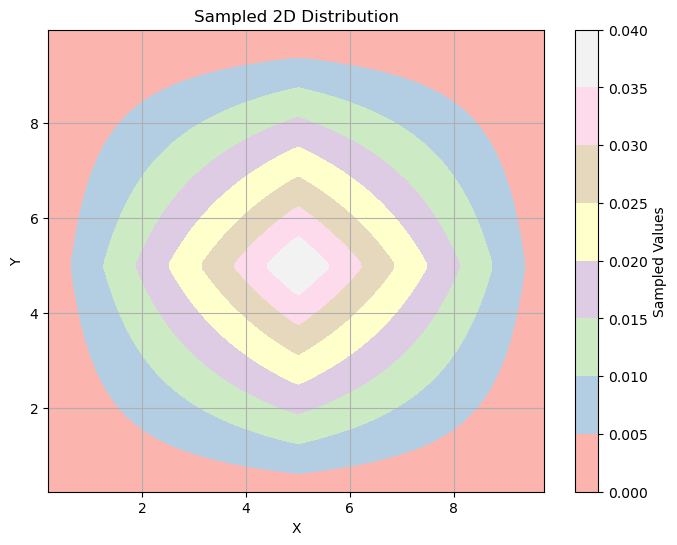

In [258]:
grid_res=100
x_grid,y_grid,samples_tr_dist=sampling(lower,upper,mode,prior_box,grid_res)

#contour plot of the sampled distribution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, samples_tr_dist, cmap='Pastel1')
plt.colorbar(label='Sampled Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sampled 2D Distribution')
plt.grid(True)
plt.show()

## 3D Plot

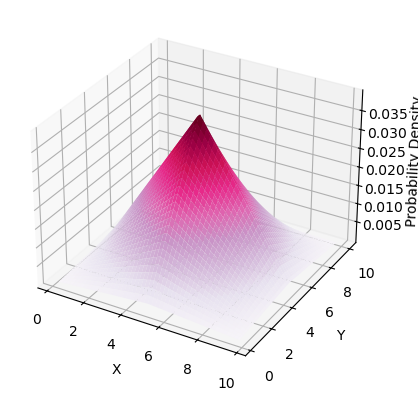

In [259]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(x_grid,y_grid,samples_tr_dist,cmap='PuRd')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability Density')
plt.show()

## Marginalization
Now I marginalize the joint distribution, represented by the array *samples_tr_dist*, over the rows of this array to obtain the marginal distribution of $x$, and over the columns to obtain the marginal distribution of $y$.

In [260]:
marginal_x=np.sum(samples_tr_dist,axis=1)
marginal_y=np.sum(samples_tr_dist,axis=0)

Plot of the two 1D distributions

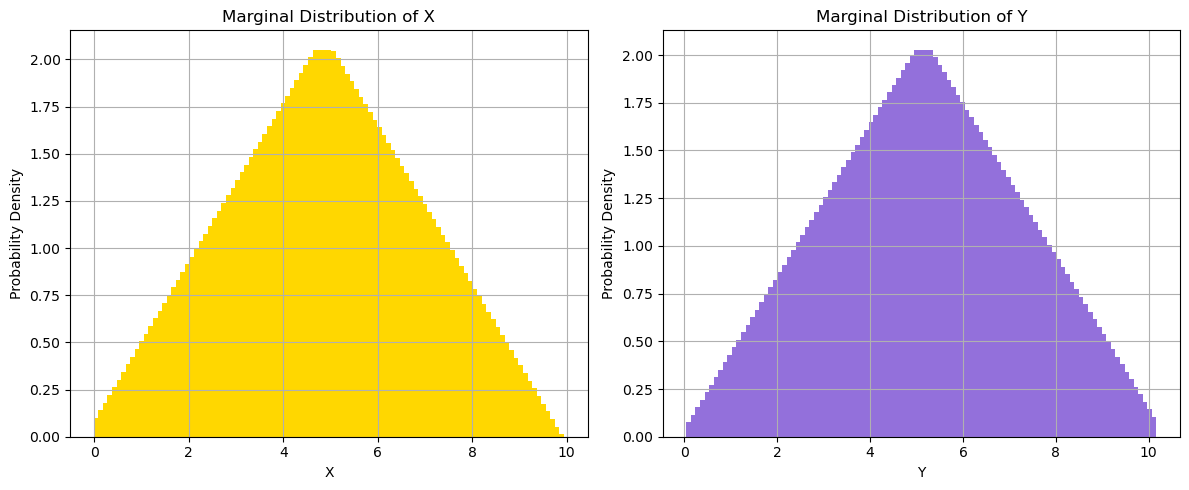

In [261]:
x_grid_1d=np.unique(x_grid)
y_grid_1d=np.unique(y_grid)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#marginal distribution of x
axs[0].bar(x_grid_1d, marginal_x, width=0.4, color='gold')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Marginal Distribution of X')
axs[0].grid(True)

#marginal distribution of y
axs[1].bar(y_grid_1d, marginal_y, width=0.4, color='mediumpurple')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Marginal Distribution of Y')
axs[1].grid(True)

plt.tight_layout()
plt.show()

Both plots show bars which are higer around the mode of the triangular distribution ($mode_x=5, mode_y=5$), indicating higher probability density around this value.

### Check that the 1D distributions are normalized

* First, I define the marginal distribution functions:

In [262]:
def marginal_x_function(x):
    return np.interp(x, x_grid_1d, marginal_x)

def marginal_y_function(y):
    return np.interp(y, y_grid_1d, marginal_y)

* Then, I normalize them:

In [263]:
N_x, _ = integrate.quad(marginal_x_function, np.min(x_grid_1d), np.max(x_grid_1d))
N_y, _ = integrate.quad(marginal_y_function, np.min(y_grid_1d), np.max(y_grid_1d))

#print("Scaling factor for marginal x:", 1 / N_x)
#print("Scaling factor for marginal y:", 1 / N_y)

* Finally, I define the *normalized* marginal distribution functions and I verify that they are normalized:

In [264]:
def marginal_x_function_normalized(x):
    return np.interp(x, x_grid_1d, marginal_x)/N_x

def marginal_y_function_normalized(y):
    return np.interp(y, y_grid_1d, marginal_y)/N_y

Norm_x,_=integrate.quad(marginal_x_function_normalized, np.min(x_grid_1d), np.max(x_grid_1d))
Norm_y,_=integrate.quad(marginal_y_function_normalized, np.min(y_grid_1d), np.max(y_grid_1d))

print("Norm of marginal x:",Norm_x)
print("Norm of marginal y:",Norm_y)

Norm of marginal x: 1.0000000000000002
Norm of marginal y: 0.9999999999999998


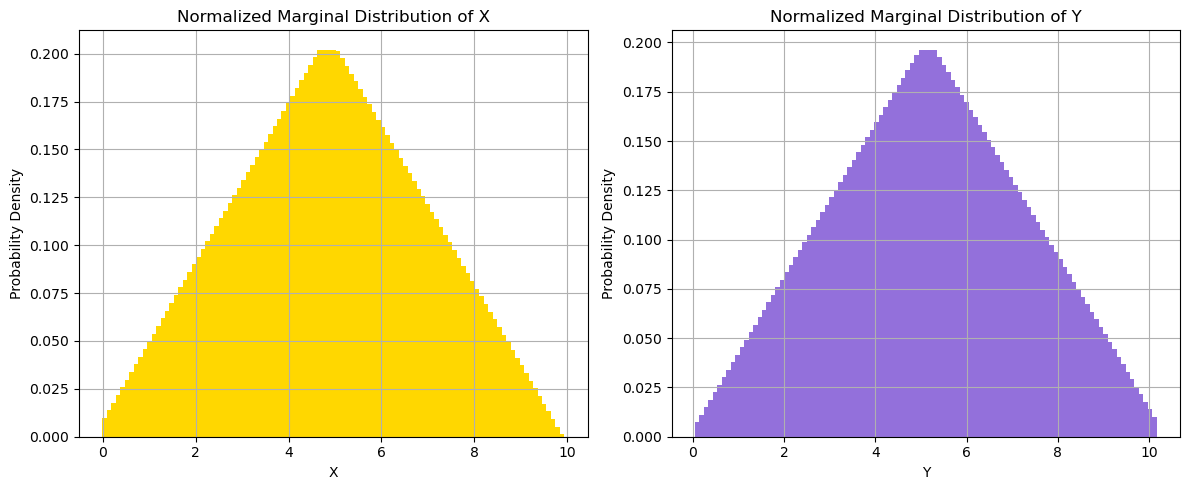

In [265]:
#plots of the normalized marginal distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(x_grid_1d, marginal_x_function_normalized(x_grid_1d), width=0.4, color='gold')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Normalized Marginal Distribution of X')
axs[0].grid(True)

axs[1].bar(y_grid_1d, marginal_y_function_normalized(y_grid_1d), width=0.4, color='mediumpurple')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Normalized Marginal Distribution of Y')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Cumulative Distribution Function of the 1D Distribution

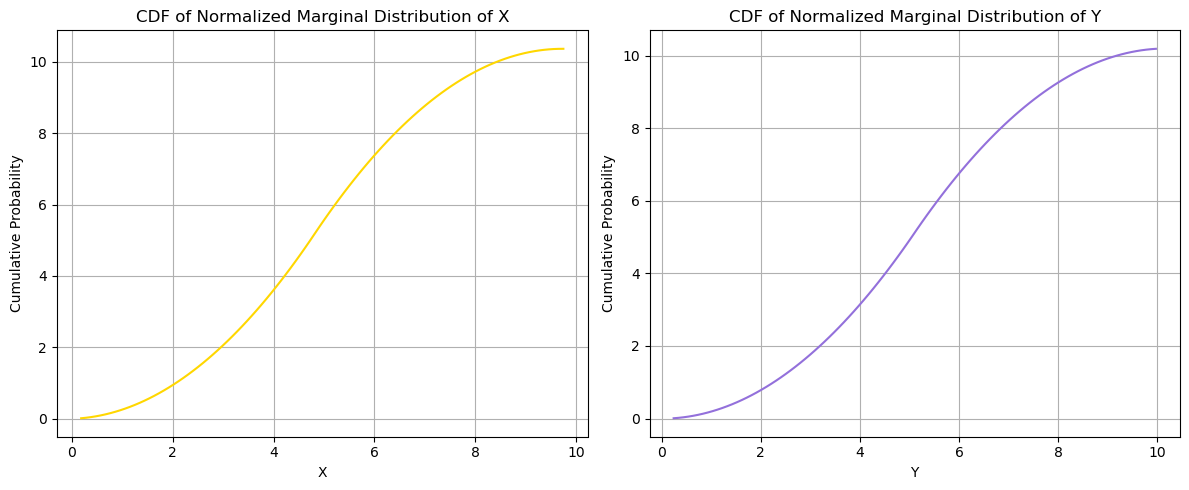

Integral of CDF for normalized marginal x: 10.364815621682942
Integral of CDF for normalized marginal y: 10.185999228548223


In [266]:
#CDF for the normalized marginal distributions
cdf_marginal_x = np.cumsum(marginal_x_function_normalized(x_grid_1d))
cdf_marginal_y = np.cumsum(marginal_y_function_normalized(y_grid_1d))

#plot of the CDF for the normalized marginal distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(x_grid_1d, cdf_marginal_x, color='gold')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Cumulative Probability')
axs[0].set_title('CDF of Normalized Marginal Distribution of X')
axs[0].grid(True)

axs[1].plot(y_grid_1d, cdf_marginal_y, color='mediumpurple')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Cumulative Probability')
axs[1].set_title('CDF of Normalized Marginal Distribution of Y')
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("Integral of CDF for normalized marginal x:", cdf_marginal_x[-1])
print("Integral of CDF for normalized marginal y:", cdf_marginal_y[-1])


In [267]:
'''
cdf_marginal_x = np.cumsum(marginal_x_function_normalized(x_grid))
cdf_marginal_y = np.cumsum(marginal_y_function_normalized(y_grid))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(np.arange(len(cdf_marginal_x)), cdf_marginal_x, color='gold')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Cumulative Probability')
axs[0].set_title('CDF of Normalized Marginal Distribution of X')
axs[0].grid(True)

axs[1].plot(np.arange(len(cdf_marginal_y)), cdf_marginal_y, color='mediumpurple')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Cumulative Probability')
axs[1].set_title('CDF of Normalized Marginal Distribution of Y')
axs[1].grid(True)

plt.tight_layout()
plt.show()
'''

"\ncdf_marginal_x = np.cumsum(marginal_x_function_normalized(x_grid))\ncdf_marginal_y = np.cumsum(marginal_y_function_normalized(y_grid))\n\nfig, axs = plt.subplots(1, 2, figsize=(12, 5))\n\naxs[0].plot(np.arange(len(cdf_marginal_x)), cdf_marginal_x, color='gold')\naxs[0].set_xlabel('X')\naxs[0].set_ylabel('Cumulative Probability')\naxs[0].set_title('CDF of Normalized Marginal Distribution of X')\naxs[0].grid(True)\n\naxs[1].plot(np.arange(len(cdf_marginal_y)), cdf_marginal_y, color='mediumpurple')\naxs[1].set_xlabel('Y')\naxs[1].set_ylabel('Cumulative Probability')\naxs[1].set_title('CDF of Normalized Marginal Distribution of Y')\naxs[1].grid(True)\n\nplt.tight_layout()\nplt.show()\n"

## Mean, median and mode

- Computation of *mean*, *median* and *mode*.

In [268]:
def Stats(function, x):
    #mean
    mean = integrate.quad(lambda x: x * function(x), np.min(x), np.max(x))[0]
    #median
    median = np.median(x)
    #mode
    mode_index = np.argmax(function(x))
    mode = x[mode_index]
    
    return mean, median, mode

mean_x, median_x, mode_x = Stats(marginal_x_function_normalized, np.linspace(np.min(x_grid), np.max(x_grid), len(marginal_x)))
mean_y, median_y, mode_y = Stats(marginal_y_function_normalized, np.linspace(np.min(y_grid), np.max(y_grid), len(marginal_y)))

#'''
print(f"Mean of normalized marginal distribution of X: {mean_x}")
print(f"Median of normalized marginal distribution of X: {median_x}")
print(f"Mode of normalized marginal distribution of X: {mode_x}")

print(f"Mean of normalized marginal distribution of Y: {mean_y}")
print(f"Median of normalized marginal distribution of Y: {median_y}")
print(f"Mode of normalized marginal distribution of Y: {mode_y}")
#'''

Mean of normalized marginal distribution of X: 4.8679774925665935
Median of normalized marginal distribution of X: 4.96559819348005
Mode of normalized marginal distribution of X: 4.820800237801059
Mean of normalized marginal distribution of Y: 5.136948299240209
Median of normalized marginal distribution of Y: 5.104902455765168
Mode of normalized marginal distribution of Y: 5.154031542817588


- Addition of the values to the plots of the *cdf*.

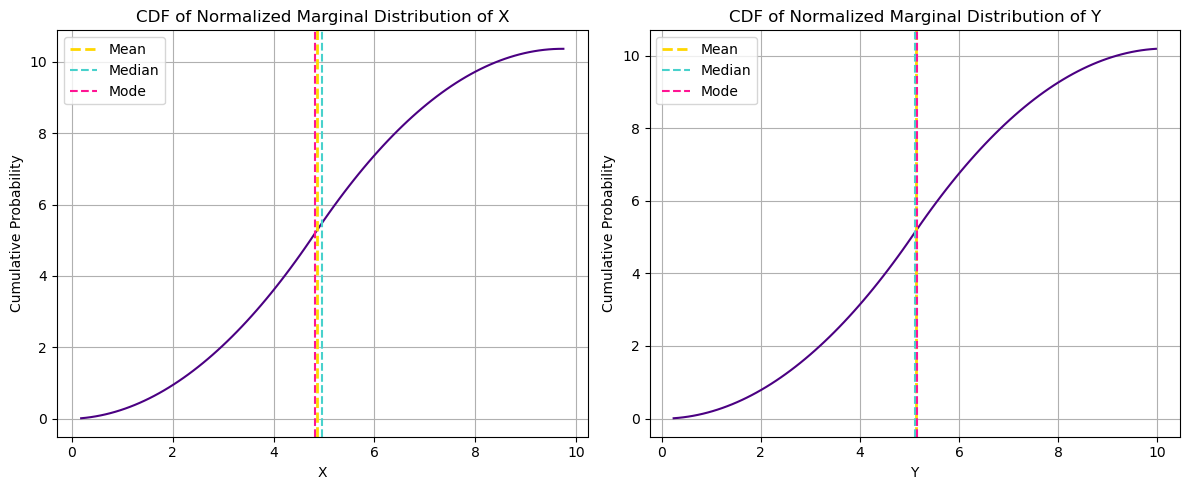

In [269]:
'''
#SINCE THE CDFS DO NOT REACH 1, I HAVE TO RESCALE THE VALUES OF THE MEAN, MEDIAN AND MODE
scaled_mean_x = mean_x * (len(marginal_x) - 1) / (upper_x - lower_x)
scaled_median_x = median_x * (len(marginal_x) - 1) / (upper_x - lower_x)
scaled_mode_x = mode_x * (len(marginal_x) - 1) / (upper_x - lower_x)

scaled_mean_y = mean_y * (len(marginal_y) - 1) / (upper_y - lower_y)
scaled_median_y = median_y * (len(marginal_y) - 1) / (upper_y - lower_y)
scaled_mode_y = mode_y * (len(marginal_y) - 1) / (upper_y - lower_y)
'''

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(x_grid_1d, cdf_marginal_x, color='indigo')
axs[0].axvline(mean_x, color='gold', linestyle='--', label='Mean', linewidth=2)
axs[0].axvline(median_x, color='mediumturquoise', linestyle='--', label='Median')
axs[0].axvline(mode_x, color='deeppink', linestyle='--', label='Mode')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Cumulative Probability')
axs[0].set_title('CDF of Normalized Marginal Distribution of X')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(y_grid_1d, cdf_marginal_y, color='indigo')
axs[1].axvline(mean_y, color='gold', linestyle='--', label='Mean', linewidth=2)
axs[1].axvline(median_y, color='mediumturquoise', linestyle='--', label='Median')
axs[1].axvline(mode_y, color='deeppink', linestyle='--', label='Mode')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Cumulative Probability')
axs[1].set_title('CDF of Normalized Marginal Distribution of Y')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

## Variance
**N.B.**: the formula of the sample variance with $N$ observations is

$\text{var}=\frac{\sum_{i=1}^{N}(x_i-\text{mean})^2}{N}$,

while the formula with Bessel's correction (which corrects the bias in the estimation of the population variance simply dividing the sum of squared deviations by $N-1$ instead of $N$) is

$\text{var}_B=\frac{\sum_{i=1}^{N}(x_i-\text{mean})^2}{N-1}$.

This is the reason for using `ddof=1` in the calculation of the variance.

In [270]:
var_x_original=stats.tvar(marginal_x,ddof=1)
print(var_x_original)

var_y_original=stats.tvar(marginal_y,ddof=1)
print(var_y_original)

var_x_normalized=stats.tvar(marginal_x_function_normalized(np.arange(len(marginal_x))),ddof=1)
print(var_x_normalized)

var_y_normalized=stats.tvar(marginal_y_function_normalized(np.arange(len(marginal_y))),ddof=1)
print(var_y_normalized)

0.34882765522154985
0.32455998522132595
0.0012576516903901739
0.0010601524489091117


- Manual computation (for verifying)

In [271]:
'''
mean_x_original = np.mean(marginal_x)
n_x = len(marginal_x)
variance_x_manual = np.sum((marginal_x - mean_x_original)**2) / (n_x - 1)
print(f"Mean of original marginal distribution of X: {mean_x_original}")
print(f"Variance of original marginal distribution of X (manual calculation): {variance_x_manual}")

mean_y_original = np.mean(marginal_y)
n_y = len(marginal_y)
variance_y_manual = np.sum((marginal_y - mean_y_original)**2) / (n_y - 1)
print(f"Mean of original marginal distribution of Y: {mean_y_original}")
print(f"Variance of original marginal distribution of Y (manual calculation): {variance_y_manual}")

mean_x_normalized = np.mean(marginal_x_function_normalized(np.arange(len(marginal_x))))
n_x_normalized = len(marginal_x)
variance_x_normalized_manual = np.sum((marginal_x_function_normalized(np.arange(len(marginal_x))) - mean_x_normalized)**2) / (n_x_normalized - 1)
print(f"Mean of normalized marginal distribution of X: {mean_x_normalized}")
print(f"Variance of normalized marginal distribution of X (manual calculation): {variance_x_normalized_manual}")

mean_y_normalized = np.mean(marginal_y_function_normalized(np.arange(len(marginal_y))))
n_y_normalized = len(marginal_y)
variance_y_normalized_manual = np.sum((marginal_y_function_normalized(np.arange(len(marginal_y))) - mean_y_normalized)**2) / (n_y_normalized - 1)
print(f"Mean of normalized marginal distribution of Y: {mean_y_normalized}")
print(f"Variance of normalized marginal distribution of Y (manual calculation): {variance_y_normalized_manual}")
'''

'\nmean_x_original = np.mean(marginal_x)\nn_x = len(marginal_x)\nvariance_x_manual = np.sum((marginal_x - mean_x_original)**2) / (n_x - 1)\nprint(f"Mean of original marginal distribution of X: {mean_x_original}")\nprint(f"Variance of original marginal distribution of X (manual calculation): {variance_x_manual}")\n\nmean_y_original = np.mean(marginal_y)\nn_y = len(marginal_y)\nvariance_y_manual = np.sum((marginal_y - mean_y_original)**2) / (n_y - 1)\nprint(f"Mean of original marginal distribution of Y: {mean_y_original}")\nprint(f"Variance of original marginal distribution of Y (manual calculation): {variance_y_manual}")\n\nmean_x_normalized = np.mean(marginal_x_function_normalized(np.arange(len(marginal_x))))\nn_x_normalized = len(marginal_x)\nvariance_x_normalized_manual = np.sum((marginal_x_function_normalized(np.arange(len(marginal_x))) - mean_x_normalized)**2) / (n_x_normalized - 1)\nprint(f"Mean of normalized marginal distribution of X: {mean_x_normalized}")\nprint(f"Variance of n

## Gaussian Approximation

0.10364815621682942 0.10185999228548225


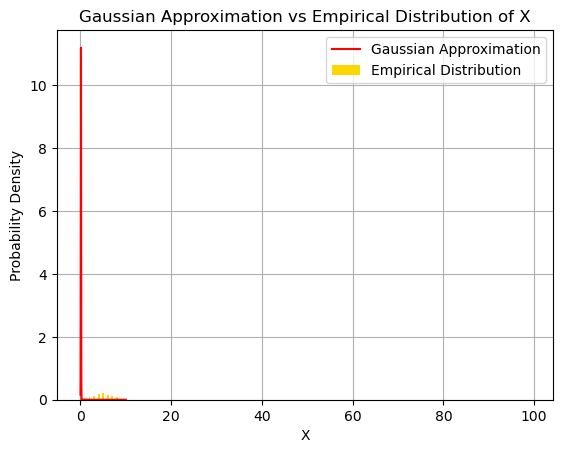

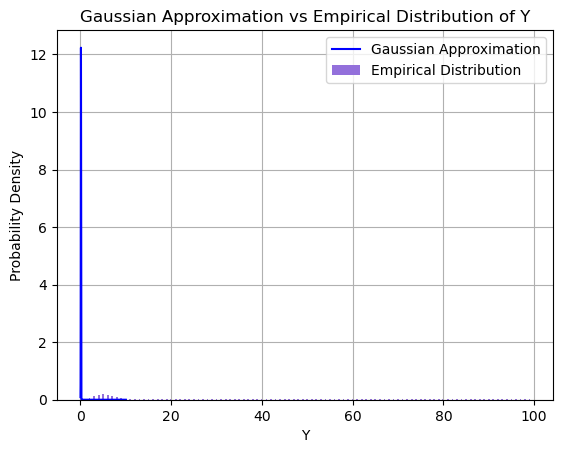

In [272]:
mean_x = np.mean(marginal_x_function_normalized(x_grid_1d))
mean_y = np.mean(marginal_y_function_normalized(y_grid_1d))

print(mean_x,mean_y)

std_x=np.sqrt(var_x_normalized)
std_y=np.sqrt(var_y_normalized)

x_values = np.linspace(lower_x, upper_x, size_pb)
gaussian_x = stats.norm.pdf(x_values, mean_x, std_x)
plt.plot(x_values, gaussian_x, label='Gaussian Approximation', color='red')
plt.bar(range(len(marginal_x)), marginal_x_function_normalized(np.arange(len(marginal_x))), width=0.4, color='gold', label='Empirical Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Gaussian Approximation vs Empirical Distribution of X')
plt.legend()
plt.grid(True)
plt.show()

y_values = np.linspace(lower_y, upper_y, size_pb)
gaussian_y = stats.norm.pdf(y_values, mean_y, std_y)
plt.plot(y_values, gaussian_y, label='Gaussian Approximation', color='blue')
plt.bar(range(len(marginal_y)), marginal_y_function_normalized(np.arange(len(marginal_y))), width=0.4, color='mediumpurple', label='Empirical Distribution')
plt.xlabel('Y')
plt.ylabel('Probability Density')
plt.title('Gaussian Approximation vs Empirical Distribution of Y')
plt.legend()
plt.grid(True)
plt.show()
